In [1]:
import numpy as np
from proj1_helpers import load_csv_data, predict_labels, create_csv_submission

In [2]:
def compute_mse(y, tx, w):
    """Calculate the loss using mse."""
    N = y.shape[0]
    e = y - tx @ w.T
    return 1 / (2 * N) * np.linalg.norm(e) ** 2

def compute_gradient(y, tx, w):
    """Compute the gradient."""
    N = y.shape[0]
    e = y - tx @ w.T
    return -1 / N * tx.T @ e 

def least_squares_GD(y, tx, initial_w, max_iters, gamma):
    """Least squares using gradient descent algorithm."""
    w = initial_w
    
    for _ in range(max_iters):
        DL = compute_gradient(y, tx, w)        
        w = w - DL * gamma
        
    return w, compute_mse(y, tx, w)

def least_squares_SGD(y, tx, initial_w, batch_size, max_iters, gamma):
    """Least squares using stochastic gradient descent algorithm."""
    w = initial_w
    
    for _ in range(max_iters):        
        for yn, txn in batch_iter(y, tx, batch_size):
            DL_n = compute_stoch_gradient(yn, txn, w)
            w = w - DL_n * gamma
                        
    return w, compute_mse(y, tx, w)

def least_squares(y, tx):
    """Least squares using normal equation."""
    a = tx.T @ tx
    b = tx.T @ y
    w = np.linalg.solve(a, b)
    return w, compute_mse(y, tx, w)

def ridge_regression(y, tx, lambda_):
    """Ridge regression."""
    N = tx.shape[0]
    a = (tx.T @ tx) + 2 * N * lambda_ * np.eye(tx.shape[1])
    b = tx.T @ y
    w = np.linalg.solve(a, b)
    return w, compute_mse(y, tx, w)

def sigmoid(t):
    """Sigmoid function on t."""
    return 1 / (1 + np.exp(-t))

def calculate_loss(y, tx, w):
    """Cost by negative log likelihood."""
    sigma_tx_w = sigmoid(tx @ w)
    sum_terms = y * np.log(sigma_tx_w) + (1 - y) * np.log(sigma_tx_w)
    return -sum_terms.sum()

def calculate_gradient(y, tx, w):
    """Gradient of loss."""
    tx_w = tx @ w
    sigma_tx_w = sigmoid(tx_w)
    # print('simga_tx_w - y')
    # print(sigma_tx_w - y)
    grad = tx.T @ (sigma_tx_w - y)
    # print('tx.T')
    # print(tx.T.shape)
    return grad

def logistic_regression(y, tx, initial_w, max_iters, gamma):
    '''Logistic regression.'''
    w = initial_w
    
    for _ in range(max_iters):
        # time.sleep(3) 
        grad = calculate_gradient(y, tx, w)
        #print('grad')
        #print(grad)
        # print('w')
        # print(w)
        w = w - gamma * grad
        
    return w, calculate_loss(y, x, w)

def reg_logistic_regression(y, tx, lambda_, initial_w, max_iters, gamma):
    w = initial_w
    
    for _ in range(max_iters):
        grad = calculate_gradient(y, tx, w) + lambda_ * np.sum(w)
        w = w - gamma * grad
        
    return w, calculate_loss(y, tx, w)

def standardize(x):
    """Standardize the original data set."""
    mean_x = np.mean(x, axis=0)
    x = x - mean_x
    std_x = np.std(x, axis=0)
    x = x / std_x
    return x, mean_x, std_x

In [3]:
def split_data(x, y, ratio, seed=None):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing
    """
    # set seed
    if not seed is None:
        np.random.seed(seed)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data based on the given ratio: TODO
    # ***************************************************
    d = x.shape[0]
    di = int(d * ratio)
    
    per = np.random.permutation(d)
    
    xtraining = x[per][:di]
    ytraining = y[per][:di]
    xtesting = x[per][di:]
    ytesting = y[per][di:]
    
    return xtraining, ytraining, xtesting, ytesting

In [4]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # polynomial basis function: TODO
    # this function should return the matrix formed
    # by applying the polynomial basis to the input data
    # ***************************************************
    phi = np.ones((x.shape[0], 1))
    for deg in range(1, degree+1):
        phi = np.c_[phi, x ** deg]
    return phi

------------
# Importing data

In [5]:
# yb, input_data, ids = load_csv_data('C:/Users/Thibaud/Documents/data/train.csv', True)

In [6]:
yb_full, input_data_full, ids_full = load_csv_data('C:/Users/Thibaud/Documents/data/train.csv')

In [7]:
yb_test, input_data_test, ids_test = load_csv_data('C:/Users/Thibaud/Documents/data/test.csv')

In [200]:
np.random.seed(16)
per = np.random.permutation(250000)
per

array([221414, 147172, 109625, ..., 133241, 244974, 105129])

In [201]:
yb, input_data, ids = yb_full[per][::10], input_data_full[per][::10], ids_full[per][::10]

In [161]:
yb.shape, input_data.shape, ids.shape

((25000,), (25000, 30), (25000,))

------------------------
# Treating nans

In [11]:
def replace_nans_with_mean(arr, nan=-999):
    '''Creates a copy and replaces the nan values by the mean (without those nan values) in the column'''
    N, D = arr.shape
    copy = arr.copy()
    
    for d in range(D):
        copy[:,d][copy[:,d] == nan] = np.mean(arr[:,d][arr[:,d] != nan])
        
    return copy

In [12]:
def replace_nans_with_most_frequent(arr, nan=-999):
    '''Creates a copy and replaces the nan values by the most frequent value in the column'''
    N, D = arr.shape
    copy = arr.copy()
    
    for d in range(D):
        unique, counts = np.unique(arr[:,d], return_counts=True)
        copy[:,d][copy[:,d] == nan] = unique[np.argmax(counts[unique != nan])]
        
    return copy

In [13]:
def replace_nans_with_median(arr, nan=-999):
    '''Creates a copy and replaces the nan values by the median (without thos nan values) in the column'''
    N, D = arr.shape
    copy = arr.copy()
    
    for d in range(D):
        copy[:,d][copy[:,d] == nan] = np.median(arr[:,d][arr[:,d] != nan])
        
    return copy

In [14]:
def prediction(w, x_test, y_test, small=-1, big=1, verbose=False):
    y_pred = x_test @ w
    sep_val = (small + big) / 2
    y_pred[y_pred < sep_val] = small
    y_pred[y_pred >= sep_val] = big
    
    bad = np.count_nonzero(y_pred - y_test)
    good = y_test.shape[0] - bad
    
    ratio = good / (good + bad)
    
    if verbose:
        print('Good: ', good)
        print('Bad: ', bad)
        print('Ratio: ', ratio)
    
    return ratio

------------
# Separating data

Data separated by the value in column 22 which is a categorical column

In [15]:
def separate_by_col22(x, idd, y):    
    x_22 = [np.delete(x[x[:,22] == i], 22, 1) for i in range(4)]
    idd_22 = [idd[x[:,22] == i] for i in range(4)]
    y_22 = [y[x[:,22] == i] for i in range(4)]
    
    return x_22, idd_22, y_22

In [202]:
input_data_by_22, ids_by_22, yb_by_22 = separate_by_col22(input_data, ids, yb)

Seeing the eprcentages of -999 in each column of the separated data

In [203]:
for i_22 in range(4):
    print(i_22)
    for c in range(input_data_by_22[i_22].shape[1]):
        tmp = input_data_by_22[i_22][:,c]
        
        if np.any(tmp[tmp == -999]):
            print('  ', c, ':', int(len(tmp[tmp == -999]) / len(tmp) * 100))

0
   0 : 26
   4 : 100
   5 : 100
   6 : 100
   12 : 100
   22 : 100
   23 : 100
   24 : 100
   25 : 100
   26 : 100
   27 : 100
1
   0 : 9
   4 : 100
   5 : 100
   6 : 100
   12 : 100
   25 : 100
   26 : 100
   27 : 100
2
   0 : 5
3
   0 : 6


In [204]:
def delete_useless_col(x):
    useless_cols = [[4, 5, 6, 12, 22, 23, 24, 25, 26, 27, 28], [4, 5, 6, 12, 25, 26, 27], [], []]
    return [np.delete(x[i], useless_cols[i], 1) for i in range(4)]

In [205]:
only_good_data = delete_useless_col(input_data_by_22)

In [206]:
yb_by_22[0].shape, yb.shape

((10016,), (25000,))

In [207]:
np.any(only_good_data[3] == -999)

True

In [208]:
def pseudo_cross_validation():
    bests = []
    
    for i_22 in range(4):
        print('starting ', i_22)
        input_data_clean = replace_nans_with_median(only_good_data[i_22])
        input_data_std, _, _ = standardize(input_data_clean)

        times = 200
        degrees = np.linspace(6, 9, 4).astype(int) # [1, 2, 3]
        lambdas = np.logspace(-7, -4, 20) # [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]

        rmse_tr = np.zeros([times, len(degrees), len(lambdas)])
        rmse_te = np.zeros([times, len(degrees), len(lambdas)])

        for time in range(times):
            x_tr, y_tr, x_te, y_te = split_data(input_data_std, yb_by_22[i_22], 0.3, seed=time)

            for i, degree in enumerate(degrees):
                phi_tr = build_poly(x_tr, degree)
                phi_te = build_poly(x_te, degree)

                for j, lambda_ in enumerate(lambdas):
                    try:
                        w, _ = ridge_regression(y_tr, phi_tr, lambda_)

                        rmse_tr[time, i, j] = np.sqrt(2 * compute_mse(y_tr, phi_tr, w))
                        rmse_te[time, i, j] = np.sqrt(2 * compute_mse(y_te, phi_te, w))
                    except:
                        rmse_tr[time, i, j] = 1
                        rmse_te[time, i, j] = 1

            if time == 0.1 * times:
                print('  10%')
            if time == 0.2 * times:
                print('  20%')
            if time == 0.3 * times:
                print('  30%')
            if time == 0.4 * times:
                print('  40%')
            if time == 0.5 * times:
                print('  50%')
            if time == 0.6 * times:
                print('  60%')
            if time == 0.7 * times:
                print('  70%')
            if time == 0.8 * times:
                print('  80%')
            if time == 0.9 * times:
                print('  90%')
            if time == times - 1:
                print(' 100%')
        
        pos = np.unravel_index(np.median(rmse_te, axis=0).argmin(), np.median(rmse_te, axis=0).shape)
        bests.append((degrees[pos[0]], lambdas[pos[1]]))
        
    return bests

In [209]:
def pseudo_cross_validation_2():
    bests = []
    
    for i_22 in range(4):
        print('starting ', i_22)
        input_data_clean = replace_nans_with_median(only_good_data[i_22])
        input_data_std, _, _ = standardize(input_data_clean)
        
        N = input_data_std.shape[0]

        degrees = np.linspace(1, 14, 14).astype(int) # [1, 2, 3]
        lambdas = np.logspace(-10, 0, 30) # [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]

        predictions = np.zeros([len(degrees), len(lambdas)])

        for i, degree in enumerate(degrees):
            phi = build_poly(input_data_std, degree)

            for j, lambda_ in enumerate(lambdas):
                try:
                    w, _ = ridge_regression(yb_by_22[i_22], phi, lambda_)

                    predictions[i, j] = prediction(w, phi, yb_by_22[i_22])
                except:
                    print('oops')
                    predictions[i, j] = 0
        
        pos = np.unravel_index(predictions.argmax(), predictions.shape)
        bests.append((degrees[pos[0]], lambdas[pos[1]]))
        
    return bests

In [278]:
def pseudo_cross_validation_3():
    bests = []
    
    for i_22 in range(4):
        print('starting ', i_22)
        input_data_clean = replace_nans_with_median(only_good_data[i_22])
        input_data_std, _, _ = standardize(input_data_clean)

        times = 200
        degrees = np.linspace(2, 10, 9).astype(int) # [1, 2, 3]
        lambdas = np.logspace(-5, -1, 14) # [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]

        predictions = np.zeros([times, len(degrees), len(lambdas)])

        for time in range(times):
            x_tr, y_tr, x_te, y_te = split_data(input_data_std, yb_by_22[i_22], 0.3, seed=time)

            for i, degree in enumerate(degrees):
                phi_tr = build_poly(x_tr, degree)
                phi_te = build_poly(x_te, degree)

                for j, lambda_ in enumerate(lambdas):
                    try:
                        w, _ = ridge_regression(y_tr, phi_tr, lambda_)
                        
                        predictions[time, i, j] = prediction(w, phi_te, y_te)
                    except:
                        predictions[time, i, j] = 0

            if time == 0.1 * times:
                print('  10%')
            if time == 0.2 * times:
                print('  20%')
            if time == 0.3 * times:
                print('  30%')
            if time == 0.4 * times:
                print('  40%')
            if time == 0.5 * times:
                print('  50%')
            if time == 0.6 * times:
                print('  60%')
            if time == 0.7 * times:
                print('  70%')
            if time == 0.8 * times:
                print('  80%')
            if time == 0.9 * times:
                print('  90%')
            if time == times - 1:
                print(' 100%')
        
        pos = np.unravel_index(np.median(predictions, axis=0).argmax(), np.median(predictions, axis=0).shape)
        bests.append((degrees[pos[0]], lambdas[pos[1]]))
        
    return bests

In [279]:
pseudo_cross_validation_3()

starting  0
  10%
  20%
  30%
  40%
  50%
  60%
  70%
  80%
  90%
 100%
starting  1
  10%
  20%
  30%
  40%
  50%
  60%
  70%
  80%
  90%
 100%
starting  2
  10%
  20%
  30%
  40%
  50%
  60%
  70%
  80%
  90%
 100%
starting  3
  10%
  20%
  30%
  40%
  50%
  60%
  70%
  80%
  90%
 100%


[(10, 0.0014251026703029992),
 (10, 0.0028942661247167516),
 (7, 0.0058780160722749115),
 (3, 0.024244620170823308)]

In [280]:
bests = _

In [281]:
bests

[(10, 0.0014251026703029992),
 (10, 0.0028942661247167516),
 (7, 0.0058780160722749115),
 (3, 0.024244620170823308)]

In [14]:
bests = [(2, 0.0038566204211634724), (2, 0.03562247890262444), (3, 0.062101694189156162), (2, 0.32903445623126709)] 

In [118]:
bests = [(12, 9e-06), (7, 1.65e-05), (10, 2.42e-06), (8, 4e-05)] # 0.800

In [97]:
bests = [(6, 3.1622776601683792e-06), (6, 2.2758459260747909e-05), (6, 4.3939705607607859e-07), (6, 0.0001)] # 0.804

In [173]:
bests = [(8, 0.0025808615404180769), (10, 0.00076269858590234511), (7, 0.0025808615404180769), (7, 0.0087332616238284377)] # 0.807, ::10, 7-14, -10--1

In [273]:
bests = [(10, 0.0014251026703029992), (10, 0.0028942661247167516), (7, 0.0058780160722749115), (7, 0.01193776641714437)] # 0.807 ::10, 6-10, -5--1

In [158]:
bests = [(7, 0.00059948425031894088), (10, 0.0016681005372000592), (7, 0.0016681005372000592), (6, 0.012915496650148827)] # 0.811, ::10, 6-1, -5--1 

In [74]:
bests = [(10, 1.5013107289081744e-07), (11, 0.00022539339047347934), (11, 0.0025808615404180769), (8, 0.0025808615404180769)] # supposed to be 0.817

In [75]:
bests = [(12, 0.00016102620275609426), (12, 0.0017433288221999908), (14, 7.2789538439831604e-05), (12, 6.2101694189156158e-07)] # supposed to be 0.821

In [96]:
bests = [(6, 2.06913808111479e-07), (6, 0.0001), (6, 2.3357214690901213e-05), (6, 0.0001)] # supposed to be 0.811

-------------------
# Creating submission

In [28]:
def predict(w, x_test, small=-1, big=1):
    y_pred = x_test @ w
    sep_val = (small + big) / 2
    y_pred[y_pred < sep_val] = small
    y_pred[y_pred >= sep_val] = big
    
    return y_pred

In [119]:
input_data_full_by_22, ids_full_by_22, yb_full_by_22 = separate_by_col22(input_data_full, ids_full, yb_full)
input_data_test_by_22, ids_test_by_22, yb_test_by_22 = separate_by_col22(input_data_test, ids_test, yb_test)

input_data_full_by_22[0].shape, yb_full_by_22[0].shape

((99913, 29), (99913,))

In [120]:
for i_22 in range(4):
    print(i_22)
    for c in range(input_data_full_by_22[i_22].shape[1]):
        tmp = input_data_full_by_22[i_22][:,c]
        
        if np.any(tmp[tmp == -999]):
            print('  ', c, ':', int(len(tmp[tmp == -999]) / len(tmp) * 100), '%')

0
   0 : 26 %
   4 : 100 %
   5 : 100 %
   6 : 100 %
   12 : 100 %
   22 : 100 %
   23 : 100 %
   24 : 100 %
   25 : 100 %
   26 : 100 %
   27 : 100 %
1
   0 : 9 %
   4 : 100 %
   5 : 100 %
   6 : 100 %
   12 : 100 %
   25 : 100 %
   26 : 100 %
   27 : 100 %
2
   0 : 5 %
3
   0 : 6 %


In [282]:
only_good_data_full = delete_useless_col(input_data_full_by_22)
only_good_data_test = delete_useless_col(input_data_test_by_22)

preds = np.zeros(4)

for i_22 in range(4):
    full_std, _, _ = standardize(only_good_data_full[i_22])
    test_std, _, _ = standardize(only_good_data_test[i_22])
    
    phi_full = build_poly(full_std, bests[i_22][0])
    phi_test = build_poly(test_std, bests[i_22][0])
    
    w, _ = ridge_regression(yb_full_by_22[i_22], phi_full, bests[i_22][1])
    
    yb_test_by_22[i_22] = predict(w, phi_test)
    
    preds[i_22] = prediction(w, phi_full, yb_full_by_22[i_22], verbose=True)

Good:  84089
Bad:  15824
Ratio:  0.8416222113238517
Good:  61279
Bad:  16265
Ratio:  0.7902481171979779
Good:  40270
Bad:  10109
Ratio:  0.7993409952559598
Good:  17210
Bad:  4954
Ratio:  0.7764843890994405


In [283]:
(preds[0] * yb_full_by_22[0].shape[0] + preds[1] * yb_full_by_22[1].shape[0] + preds[2] * yb_full_by_22[2].shape[0] + preds[3] * yb_full_by_22[3].shape[0]) / (yb_full_by_22[0].shape[0] + yb_full_by_22[1].shape[0] + yb_full_by_22[2].shape[0] + yb_full_by_22[3].shape[0])

0.811392

In [270]:
yb_submit = np.concatenate(yb_test_by_22)
ids_submit = np.concatenate(ids_test_by_22)

create_csv_submission(ids_submit, yb_submit, 'submission_by_cat.csv')

In [226]:
len(yb_submit[yb_submit == -1]) / len(yb_submit)

0.6944097367652287

In [227]:
len(yb[yb == -1]) / len(yb)

0.65972

---------------------
# Plotting some stuff and data analysis

In [187]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [188]:
sns.set(style="whitegrid", color_codes=True)

In [228]:
copy_no_nans = input_data_full.copy()

In [230]:
et = np.c_[yb_full, copy_no_nans]

In [235]:
et.shape

(250000, 31)

In [232]:
df = pd.DataFrame(et[:10000])

In [233]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,1.0,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,-0.277,258.733,2.0,67.435,2.150,0.444,46.062,1.24,-2.475,113.497
1,-1.0,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,-1.916,164.546,1.0,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226
2,-1.0,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,-2.186,260.414,1.0,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251
3,-1.0,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0.060,86.062,0.0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000
4,-1.0,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,-0.871,53.131,0.0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000


The columns that are correlated

In [243]:
gb = df.groupby(by=23)
gb.get_group(0).groupby(by=0).get_group(-1)

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
3,-1.0,143.905,81.417,80.943,0.414,-999.0,-999.0,-999.0,3.310,0.414,...,0.060,86.062,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0
4,-1.0,175.864,16.915,134.805,16.405,-999.0,-999.0,-999.0,3.891,16.405,...,-0.871,53.131,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0
8,-1.0,105.594,50.559,100.989,4.288,-999.0,-999.0,-999.0,2.904,4.288,...,0.024,129.804,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0
10,-1.0,-999.000,86.240,79.692,27.201,-999.0,-999.0,-999.0,2.338,27.201,...,0.688,250.178,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0
13,-1.0,82.488,31.663,64.128,8.232,-999.0,-999.0,-999.0,2.823,8.232,...,1.433,163.420,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0
14,-1.0,-999.000,109.412,14.398,17.323,-999.0,-999.0,-999.0,0.472,17.323,...,-1.583,198.616,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0
18,-1.0,-999.000,85.186,68.827,5.042,-999.0,-999.0,-999.0,2.116,5.042,...,-2.033,151.816,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0
19,-1.0,-999.000,88.767,115.058,15.337,-999.0,-999.0,-999.0,2.879,15.337,...,-2.577,115.145,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0
20,-1.0,-999.000,89.705,41.765,18.437,-999.0,-999.0,-999.0,1.395,18.437,...,-1.169,225.139,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0
21,-1.0,90.736,18.674,60.231,25.156,-999.0,-999.0,-999.0,2.363,25.156,...,0.645,169.061,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0


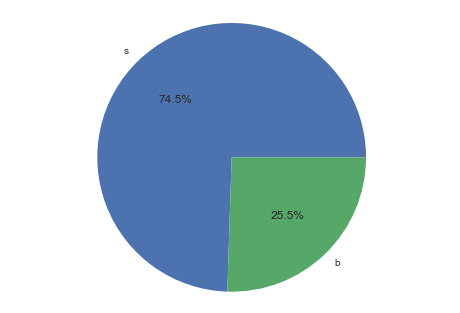

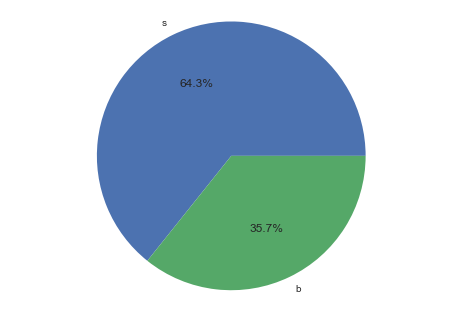

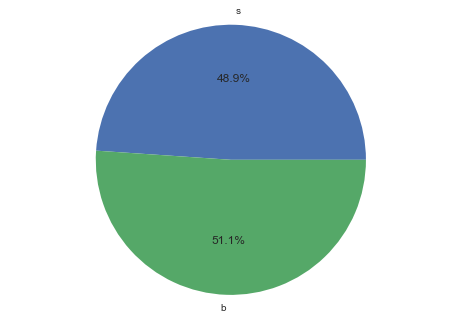

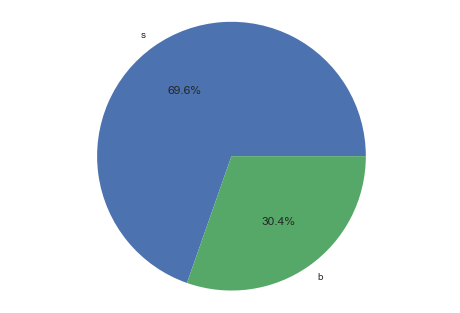

In [266]:
a = len(yb_full_by_22[0][yb_full_by_22[0] == -1])
b = len(yb_full_by_22[0][yb_full_by_22[0] ==  1])
c = len(yb_full_by_22[1][yb_full_by_22[1] == -1])
d = len(yb_full_by_22[1][yb_full_by_22[1] ==  1])
e = len(yb_full_by_22[2][yb_full_by_22[2] == -1])
f = len(yb_full_by_22[2][yb_full_by_22[2] ==  1])
g = len(yb_full_by_22[3][yb_full_by_22[3] == -1])
h = len(yb_full_by_22[3][yb_full_by_22[3] ==  1])

plt.pie([a, b], labels=['s', 'b'], autopct='%1.1f%%')
plt.axis('equal')
plt.show()
plt.pie([c, d], labels=['s', 'b'], autopct='%1.1f%%')
plt.axis('equal')
plt.show()
plt.pie([e, f], labels=['s', 'b'], autopct='%1.1f%%')
plt.axis('equal')
plt.show()
plt.pie([g, h], labels=['s', 'b'], autopct='%1.1f%%')
plt.axis('equal')
plt.show()

In [249]:
len(yb_full_by_22[1][yb_full_by_22[1] == -1]) / len(yb_full_by_22[1])

0.6426544929330444

In [250]:
len(yb_full_by_22[2][yb_full_by_22[2] == -1]) / len(yb_full_by_22[2])

0.48919192520693144

In [251]:
len(yb_full_by_22[3][yb_full_by_22[3] == -1]) / len(yb_full_by_22[3])

0.6963093304457679

In [267]:
corr = []
for i in range(0, 31):
    for j in range(i + 1, 31):
        corr.append([i, j, df[i].corr(df[j])])
        
corr_a = np.array(corr)
corr_a[np.logical_or(corr_a[:,2] > 0.8, corr_a[:,2] < -0.8)]

array([[  5.        ,   6.        ,   0.94383229],
       [  5.        ,   7.        ,   0.99998116],
       [  5.        ,  13.        ,   0.99999836],
       [  5.        ,  23.        ,   0.87013017],
       [  5.        ,  27.        ,   0.99936748],
       [  5.        ,  28.        ,   0.99999504],
       [  5.        ,  29.        ,   0.99999546],
       [  6.        ,   7.        ,   0.94218917],
       [  6.        ,  13.        ,   0.94336057],
       [  6.        ,  23.        ,   0.81494749],
       [  6.        ,  27.        ,   0.94540748],
       [  6.        ,  28.        ,   0.94333412],
       [  6.        ,  29.        ,   0.94327071],
       [  7.        ,  13.        ,   0.99998954],
       [  7.        ,  23.        ,   0.87032726],
       [  7.        ,  27.        ,   0.99936824],
       [  7.        ,  28.        ,   0.9999875 ],
       [  7.        ,  29.        ,   0.99998854],
       [ 10.        ,  22.        ,   0.905602  ],
       [ 10.        ,  30.     

In [ ]:
copy_no_nans[copy_no_nans[:,8] > 1000]

In [ ]:
for i in range(1, 31):
    #sns.violinplot(x=0, y=i, data=df)
    sns.stripplot(df[0], df[i], jitter=True)
    sns.plt.show()
    #print(df[0].corr(df[i]))

In [ ]:
grouped = df.groupby(by=[0]).describe()

In [ ]:
grouped.T.to_csv('goruped.csv')

In [ ]:
df.groupby(by=[0]).mean()